<a href="https://colab.research.google.com/github/Nikdenof/ReviewSpectrumML/blob/main/reddit_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Reddit:

In [1]:
!pip install praw

In [2]:
import praw
from praw.models import MoreComments

In [3]:
# Инициализация Reddit API
reddit = praw.Reddit(client_id='bkK83nENe7PenLMiVWY7Rg',
                     client_secret='rzex2wQb4nkwsrlqY68J4Or1W2wSyA',
                     user_agent='training')

In [4]:
url = "https://www.reddit.com/r/Bitcoin/comments/1bn6jqn/daily_discussion_march_25_2024/"
submission = reddit.submission(url=url)

In [5]:
comms = []
submission.comments.replace_more(limit=None)
for comment in submission.comments.list():
    #print(comment.body)
    comms.append(comment.body)

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



In [6]:
from pprint import pprint

In [7]:
pprint(comms[:50])

['u/oheson remember when you said $53K was the top a month ago based on '
 'blueprints on your TA wizardry and how you kept doubling down on this? How '
 'it kept going up to almost $74K, more than $20K above your prediction?\n'
 '\n'
 'How you said it was impossible for Bitcoin to hit a new ATH before the '
 'halvening. And how $53K was "like concrete bricks", only for the  price '
 'minutes later to go past $54K and never to drop below $60K again?\n'
 '\n'
 'And then you basically stopped commenting as much as you used to and started '
 'spending more of your time over in r/cc with shitcoiners?',
 "Where's that guy who spent all weekend talking about his 125x leveraged "
 'short at $65k?',
 'Just when all the TA guys were calling for a sub 60 pullback',
 'London Stock Exchange to launch market for Bitcoin\xa0 exchange traded notes '
 '(ETNS/ETFS) on May 28\n'
 '\n'
 'Plebs front run the entire world & rightfully so',
 'Its a very sunny day where I live. Almost no clouds in the very b

In [8]:
import pandas as pd

In [9]:
comms_data = pd.DataFrame(data = comms, columns=['comments'])

In [10]:
comms_data

,comments
0,u/oheson remember when you said $53K was the t...
1,Where's that guy who spent all weekend talking...
2,Just when all the TA guys were calling for a s...
3,London Stock Exchange to launch market for Bit...
4,Its a very sunny day where I live. Almost no c...
...,...
430,It works good enough for people to make a livi...
431,Probably a misunderstanding here. The question...
432,Glass half full is better than half empty right?
433,it works both ways :) since 0xFFFF FFFF FFFF F...


## Text preprocessing:

In [11]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [12]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words("english")
nltk.download('punkt')
nltk.download("wordnet")
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:
import re

In [14]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [15]:
def review_processed(text):
  text = re.sub(r'\n|\r|<.*?>|{.*?}|[.*?]|u/', '', text)
  text = re.sub(r"[^\w]", " ", text)
  #text = re.sub(r"[\d]", "", text)
  tokens = word_tokenize(text, language='english')
  tokens = [token for token in tokens if len(token) > 1]
  tokens = [token.lower() for token in tokens]
  tokens = [token for token in tokens if token not in stop_words]

  lemmas = [lemmatizer.lemmatize(token) for token in tokens]
  lemmas = ' '.join(lemmas)
  lemmas = lemmas.split()
  return lemmas

In [16]:
cleaned_data = comms_data['comments'].apply(review_processed)

In [17]:
cleaned_data = cleaned_data.to_list()

In [18]:
bigram = gensim.models.Phrases(cleaned_data, min_count = 2, threshold = 5)
trigram = gensim.models.Phrases(bigram[cleaned_data])

In [19]:
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [20]:
print(bigram_mod[bigram_mod[cleaned_data[54]]])

['keep', 'stacking']


In [21]:
print(trigram_mod[cleaned_data[1]])

['guy', 'spent', 'weekend', 'talking', '125x', 'leveraged', 'short', '65k']


In [22]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [23]:
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [24]:
data_words_bigrams = make_bigrams(cleaned_data)

In [25]:
data_words_trigrams = make_trigrams(cleaned_data)

In [26]:
data_lemmatized = data_words_bigrams

In [27]:
id2word = corpora.Dictionary(data_lemmatized)
id2word.filter_extremes(no_below=2, no_above=0.99)

In [28]:
# Create Corpus
texts = data_lemmatized

In [29]:
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [30]:
# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 2), (24, 1), (25, 1), (26, 1)]]


In [31]:
len(corpus)

435

In [32]:
id2word[2]

'almost'

In [33]:
[[(id2word[id], freq) for id, freq in enumerate(cp)] for cp in corpus[:1]]

[[('20k', (0, 1)),
  ('ago', (1, 1)),
  ('almost', (2, 1)),
  ('based', (3, 1)),
  ('basically', (4, 1)),
  ('bitcoin', (5, 1)),
  ('cc', (6, 1)),
  ('drop', (7, 1)),
  ('go', (8, 1)),
  ('going', (9, 1)),
  ('halvening', (10, 1)),
  ('hit', (11, 1)),
  ('kept', (12, 2)),
  ('later', (13, 1)),
  ('like', (14, 1)),
  ('minute', (15, 1)),
  ('month', (16, 1)),
  ('much', (17, 1)),
  ('never', (18, 1)),
  ('new_ath', (19, 1)),
  ('past', (20, 1)),
  ('price', (21, 1)),
  ('remember', (22, 1)),
  ('said', (23, 2)),
  ('ta', (24, 1)),
  ('time', (25, 1)),
  ('used', (26, 1))]]

In [34]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    perplexity_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=144,
                                           passes=10,
                                           iterations = 200,
                                           alpha='auto', eta='auto')
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

        perplexity_values.append(model.log_perplexity(corpus))

    return model_list, coherence_values, perplexity_values

In [35]:
limit=30
start=3
step=1

In [36]:
model_list, coherence_values, perplexity_values = compute_coherence_values(dictionary=id2word,
                                                                           corpus=corpus,
                                                                           texts=data_lemmatized,
                                                                           limit=limit,
                                                                           start=start,
                                                                           step=step)

3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


**Сoherence values:**

In [37]:
import matplotlib.pyplot as plt

In [38]:
import seaborn as sns

In [39]:
sns.set_theme(style='darkgrid')

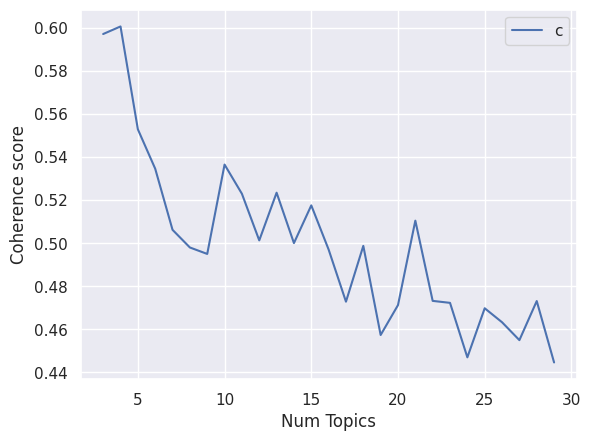

In [40]:
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [41]:
best_result_coherence_index = coherence_values.index(max(coherence_values))
optimal_model = model_list[best_result_coherence_index]

In [42]:
model_topics = optimal_model.show_topics(formatted=False)
print(f'''The {x[best_result_coherence_index]} topics gives the highest coherence score
of {coherence_values[best_result_coherence_index]}''')

The 4 topics gives the highest coherence score
of 0.6006260206340508


**Perplexity values:**

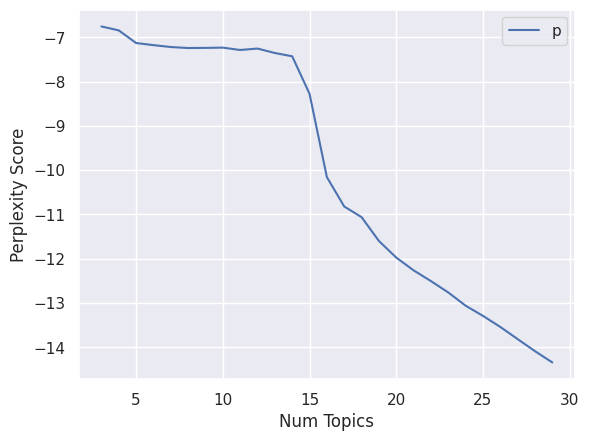

In [43]:
x = range(start, limit, step)
plt.plot(x, perplexity_values)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity Score")
plt.legend(("perplexity_values"), loc='best')
plt.show()

In [44]:
best_result_perplexity_index = perplexity_values.index(min(perplexity_values))
optimal_model = model_list[best_result_perplexity_index]

In [45]:
model_topics = optimal_model.show_topics(formatted=False)
print(f'''The {x[best_result_perplexity_index]} topics gives the lowest perplexity score
of {perplexity_values[best_result_perplexity_index]}''')

The 29 topics gives the lowest perplexity score
of -14.342133746994799


In [46]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=x[best_result_coherence_index],
                                           random_state=100,
                                           update_every=1,
                                           chunksize=512,
                                           passes=10,
                                           iterations = 200,
                                           alpha='auto', eta='auto',
                                           per_word_topics=True)

## Topics:

In [47]:
#%pip install pyLDAvis

In [48]:
#!pip install pandas==1.5.3

In [49]:
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

In [50]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.108695 -0.023063       1        1  30.103083
1     -0.128274 -0.030111       2        1  29.105927
2      0.018714 -0.078520       3        1  23.406897
3      0.000864  0.131694       4        1  17.384093, topic_info=         Term       Freq      Total Category  logprob  loglift
277  firmware  13.000000  13.000000  Default  30.0000  30.0000
5     bitcoin  48.000000  48.000000  Default  29.0000  29.0000
182   deleted  11.000000  11.000000  Default  28.0000  28.0000
232      nice   6.000000   6.000000  Default  27.0000  27.0000
121      week  11.000000  11.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
169       buy   2.889397  12.099133   Topic4  -4.9485   0.3175
9       going   2.619007  12.079285   Topic4  -5.0468   0.2209
300      know   2.427677   7.223333   Topic4  -5.1226   0.6592
432       one   2.426157  11.227061   Topic4  -5.1233   0.2176
207  coinbase   2.425605   6.359378   Topic4  -5.1235   0.7858

[255 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
166       1  0.963269     000
530       3  0.826898  0xffff
314       1  0.127668    100k
314       2  0.127668    100k
314       3  0.255337    100k
...     ...       ...     ...
378       2  0.144358    yeah
378       3  0.144358    yeah
378       4  0.721788    yeah
205       2  0.606707    year
205       3  0.364024    year

[361 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])